# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [97]:
# Import statements
import pandas as pd
import numpy as np
import requests
import tweepy
import os
import json
import time
from timeit import default_timer as timer
import re
import matplotlib.pyplot as plt
import warnings
from IPython.display import Image
from functools import reduce
import re
import seaborn as sns
import datetime
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter('ignore')

In [98]:
# Open the csv file
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
# df_twitter_archive.head()
# df_twitter_archive.tail(5)
# df_twitter_archive.info()
df_twitter_archive.shape

(2356, 17)

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [99]:
# Downloading the image prediction file from project link
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url, allow_redirects=True)
# Save File into System
with open('image_prediction.tsv', mode ='w', encoding ='UTF-8') as  file:
    file.write(response.text)
pd.read_csv('image_prediction.tsv', sep='\t')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [100]:
df_image_prediction = pd.read_csv('image_prediction.tsv', sep='\t')
# df_image_prediction.head()
# df_image_prediction.info()
df_image_prediction.shape

(2075, 12)

In [101]:
#Downloading twitter api API and JSON stuff
access_token = "910976278265769984-vE8bThY3afB3SLfXuMC4k1eT7foQNMs"
access_secret = "ZrAtZEB7sVwJkncw70DijwTs4wbBI7j9zd1BjXJ1NG71D"
consumer_key = "gBWzp0bmCRbxLTVyoyaTidBSP"
consumer_secret = "mfWKLtdg1Em7MtS43EsKmqgmaRhoTHwGjT3NEXo5uX7APNUadi"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [102]:
api = tweepy.API(auth, wait_on_rate_limit=True)

In [103]:
tweet_ids = df_twitter_archive.tweet_id.values
len(tweet_ids)

2356

In [104]:
# #from time import default_timer as timer
# count = 0
# fails_dict = {}
# start = timer()
# # save each tweets returned JSON as a new line in a .txt file
# with open ('tweet_json.txt', 'w') as outfile:
#     #This loop will likely take 20-30 minutes to run because of twitter's rate limit
#     for tweet_id in tweet_ids:
#         count += 1
#         print(str(count) + ":" + str(tweet_id))
#         try:
#             tweet = api.get_status(tweet_id, tweet_mode='extended')
#             print("succes")
#             json.dump(tweet._json, outfile)
#             outfile.write('\n')
#         except tweepy.errors.TweepyException as e:
#             print("Fail")
#             fails_dict[tweet_id] = e
#             pass
#     end = timer()
#     print(end - start)
#     print(fails_dict)


In [105]:
twitter_list = []
# Read the .txt file line by line into a list of dictionaries
for line in open('tweet_json.txt', 'r'):
    twitter_data = json.loads(line)
    twitter_list.append({'tweet_id': twitter_data['id_str'],
                        'retweet_count': twitter_data['retweet_count'],
                        'favorite_count': twitter_data['favorite_count'],
                        'followers_count': twitter_data['user']['followers_count']})

In [106]:
twitter_list

[{'tweet_id': '892420643555336193',
  'retweet_count': 7010,
  'favorite_count': 33829,
  'followers_count': 9273021},
 {'tweet_id': '892177421306343426',
  'retweet_count': 5301,
  'favorite_count': 29340,
  'followers_count': 9273021},
 {'tweet_id': '891815181378084864',
  'retweet_count': 3482,
  'favorite_count': 22069,
  'followers_count': 9273021},
 {'tweet_id': '891689557279858688',
  'retweet_count': 7228,
  'favorite_count': 36955,
  'followers_count': 9273021},
 {'tweet_id': '891327558926688256',
  'retweet_count': 7765,
  'favorite_count': 35323,
  'followers_count': 9273021},
 {'tweet_id': '891087950875897856',
  'retweet_count': 2602,
  'favorite_count': 17814,
  'followers_count': 9273021},
 {'tweet_id': '890971913173991426',
  'retweet_count': 1666,
  'favorite_count': 10370,
  'followers_count': 9273021},
 {'tweet_id': '890729181411237888',
  'retweet_count': 15761,
  'favorite_count': 56893,
  'followers_count': 9273021},
 {'tweet_id': '890609185150312448',
  'retweet_

In [107]:
# Convert the list of dictionaries to a pandas DataFrame
twitter_data = pd.DataFrame(twitter_list, columns = ['tweet_id', 'retweet_count', 'favorite_count', 'followers_count'])

In [108]:
twitter_data.head(5)
# twitter_data.info()
# twitter_data.shape

,tweet_id,retweet_count,favorite_count,followers_count
0,892420643555336193,7010,33829,9273021
1,892177421306343426,5301,29340,9273021
2,891815181378084864,3482,22069,9273021
3,891689557279858688,7228,36955,9273021
4,891327558926688256,7765,35323,9273021


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [109]:
twitter_data.head(10)

,tweet_id,retweet_count,favorite_count,followers_count
0,892420643555336193,7010,33829,9273021
1,892177421306343426,5301,29340,9273021
2,891815181378084864,3482,22069,9273021
3,891689557279858688,7228,36955,9273021
4,891327558926688256,7765,35323,9273021
5,891087950875897856,2602,17814,9273021
6,890971913173991426,1666,10370,9273021
7,890729181411237888,15761,56893,9273021
8,890609185150312448,3624,24530,9273021
9,890240255349198849,6101,27971,9273021


In [110]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         2327 non-null   object
 1   retweet_count    2327 non-null   int64 
 2   favorite_count   2327 non-null   int64 
 3   followers_count  2327 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 72.8+ KB


In [111]:
df_image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [112]:
df_image_prediction.duplicated().sum()

0

In [113]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [114]:
df_twitter_archive[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [115]:
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: rating_numerator, dtype: int64

In [116]:
df_twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

In [117]:
df_twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [118]:
df_twitter_archive.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [119]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [120]:
df_image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [121]:
df_image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [122]:
# twitter_data.info(verbose=False)
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         2327 non-null   object
 1   retweet_count    2327 non-null   int64 
 2   favorite_count   2327 non-null   int64 
 3   followers_count  2327 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 72.8+ KB


### For Twitter Data......

In [123]:
twitter_data.sample(10)

,tweet_id,retweet_count,favorite_count,followers_count
1853,674999807681908736,957,1999,9273010
1830,675497103322386432,1137,2825,9273010
1233,710153181850935296,814,2692,9273009
348,829011960981237760,15137,50338,9273023
199,852311364735569921,8890,30399,9273021
1320,704347321748819968,314,1450,9273009
1898,674051556661161984,432,1294,9273010
1163,717841801130979328,545,2281,9273009
1920,673689733134946305,571,1545,9273010
666,788070120937619456,3217,0,9273022


In [124]:
twitter_data.describe()

,retweet_count,favorite_count,followers_count
count,2327.000000,2327.000000,2.327000e+03
mean,2472.351526,7057.843146,9.273023e+06
std,4186.987386,10967.485165,6.154222e+01
min,1.000000,0.000000,9.273007e+06
25%,495.000000,1226.000000,9.273009e+06
50%,1149.000000,3053.000000,9.273011e+06
75%,2863.500000,8611.000000,9.273022e+06
max,70785.000000,144956.000000,9.273473e+06


In [125]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         2327 non-null   object
 1   retweet_count    2327 non-null   int64 
 2   favorite_count   2327 non-null   int64 
 3   followers_count  2327 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 72.8+ KB


### For df_twitter_archive........

In [126]:
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: rating_numerator, dtype: int64

In [127]:
print(df_twitter_archive.loc[df_twitter_archive.rating_numerator == 12, 'text']) 
print('\n')
print(df_twitter_archive.loc[df_twitter_archive.rating_numerator == 420, 'text'])
print('\n')
print(df_twitter_archive.loc[df_twitter_archive.rating_numerator == 1776, 'text']) 

2       This is Archie. He is a rare Norwegian Pouncin...
4       This is Franklin. He would like you to stop ca...
13      This is Ted. He does his best. Sometimes that'...
16      This is Jim. He found a fren. Taught him how t...
20      This is Gerald. He was just told he didn't get...
                              ...                        
2284    *takes several long deep breaths* omg omg oMG ...
2293    This is Pipsy. He is a fluffball. Enjoys trave...
2301              12/10 gimme now https://t.co/QZAnwgnOMB
2307    12/10 simply brilliant pup https://t.co/V6ZzG4...
2324    *internally screaming* 12/10 https://t.co/YMcr...
Name: text, Length: 558, dtype: object


188     @dhmontgomery We also gave snoop dogg a 420/10...
2074    After so many requests... here you go.\n\nGood...
Name: text, dtype: object


979    This is Atticus. He's quite simply America af....
Name: text, dtype: object


In [128]:
df_twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

In [129]:
df_twitter_archive['name'].value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [130]:
df_twitter_archive[df_twitter_archive.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [131]:
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


### For df_image_predictions........

In [132]:
df_image_prediction.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1532,789628658055020548,https://pbs.twimg.com/media/CvVTEnPXYAAWLyL.jpg,1,chow,0.260702,True,cougar,0.088143,False,Pomeranian,0.079883,True
1283,750429297815552001,https://pbs.twimg.com/media/CmoPdmHW8AAi8BI.jpg,1,golden_retriever,0.964929,True,Labrador_retriever,0.011584,True,refrigerator,0.007499,False
1373,762471784394268675,https://pbs.twimg.com/ext_tw_video_thumb/76247...,1,Samoyed,0.540276,True,standard_poodle,0.279802,True,toy_poodle,0.102058,True
265,670803562457407488,https://pbs.twimg.com/media/CU8sSAvXIAAB1Py.jpg,1,basenji,0.344101,True,Ibizan_hound,0.210282,True,toy_terrier,0.196279,True
593,679475951516934144,https://pbs.twimg.com/media/CW37xZbUoAAUXe5.jpg,1,Maltese_dog,0.145742,True,toy_poodle,0.139407,True,West_Highland_white_terrier,0.108821,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
728,686386521809772549,https://pbs.twimg.com/media/CYaI5aaW8AE8Uyk.jpg,1,Yorkshire_terrier,0.477704,True,silky_terrier,0.171673,True,Australian_terrier,0.088334,True
710,685307451701334016,https://pbs.twimg.com/media/CYKzfTTWMAEeTN7.jpg,1,Pomeranian,0.963176,True,Shetland_sheepdog,0.019468,True,keeshond,0.008605,True
743,687476254459715584,https://pbs.twimg.com/media/CYpoAZTWEAA6vDs.jpg,1,wood_rabbit,0.702725,False,Angora,0.190659,False,hare,0.105072,False
37,666454714377183233,https://pbs.twimg.com/media/CT-5Bs-WUAA2JeC.jpg,1,dalmatian,0.278954,True,Labrador_retriever,0.237612,True,Great_Pyrenees,0.171106,True


In [133]:
# sample image for s/n 1288 && tweet_id 751205363882532864
Image(url = 'https://pbs.twimg.com/media/CmzRRY1WcAEoxwY.jpg')

In [134]:
df_image_prediction['p1'].value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
pillow                  1
carousel                1
bald_eagle              1
lorikeet                1
orange                  1
Name: p1, Length: 378, dtype: int64

In [135]:
df_image_prediction['p2'].value_counts()

Labrador_retriever    104
golden_retriever       92
Cardigan               73
Chihuahua              44
Pomeranian             42
                     ... 
medicine_chest          1
quail                   1
horse_cart              1
waffle_iron             1
bagel                   1
Name: p2, Length: 405, dtype: int64

In [136]:
df_image_prediction['p3'].value_counts()

Labrador_retriever    79
Chihuahua             58
golden_retriever      48
Eskimo_dog            38
kelpie                35
                      ..
ox                     1
assault_rifle          1
axolotl                1
pot                    1
banana                 1
Name: p3, Length: 408, dtype: int64

In [137]:
df_image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [138]:
df_image_prediction[df_image_prediction.tweet_id.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


### Assessment Summary:

### Quality issues
TWITTER ARCHIVE

#1.only Keep original ratings with images (remove retweets)

#2.Drop columns not needed for analysis

#3.Error in datatypes in columns [tweet_id, retweeted_status_user_id, retweeted_status_timestamp, doggo, floofer, pupper, and puppo]

#4.Correct numerators with decimals 

#5.Sort Dog Names its very unlikely "a,an,actually" are dog names.

#6.Missing values in 'name' and dog stages represented as 'None'

#7.scrub Html strings from source and tweet

API TABLE (TWITTER DATA)

8.Missing tweets

9.Error in data type for tweet_id

IMAGE TABLE (IMAGE PREDICTION TABLE)

10.Missing images 2075 obtained, instead of 2356 expected

11.Also possess Error in data type for tweet_id



### Tidiness issues

TWITTER ARCHIVE

#1. merge all 3 dataframe tables together

#2. Drop any tweet that have no images

#3. doggo, floofer, pupper and puppo columns in twitter_archive table should be merged into one column named "dog_stage"

IMAGE PREDICTION
2.Image predictions table should be added to twitter archive df

3.twitter api table columns(retweet_count, favorite_count, followers_count) should be added to twitter archive table.

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [139]:
# Make copies of original pieces of data
twitter_data_clean = twitter_data.copy()
df_image_prediction_clean = df_image_prediction.copy()
df_twitter_archive_clean = df_twitter_archive.copy()

In [140]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

### Issue #1: Quality

#### Define:
only Keep original ratings with images (remove retweets)

#### Code: 

In [141]:
#Delete retweets by filtering the NaN of retweeted_status_user_id
df_twitter_archive_clean = df_twitter_archive_clean[pd.isnull(df_twitter_archive_clean['retweeted_status_user_id'])]

#### Test:

In [142]:
print(sum(df_twitter_archive_clean.retweeted_status_user_id.value_counts()))

0


### Issue #1: Quality

#### Define:
Drop all columns not needed for analysis

#### Code

In [143]:
df_twitter_archive_clean = df_twitter_archive_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
                                            'retweeted_status_user_id','retweeted_status_timestamp', 'expanded_urls'], 1)

#### Test

In [144]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   int64 
 1   timestamp           2175 non-null   object
 2   source              2175 non-null   object
 3   text                2175 non-null   object
 4   rating_numerator    2175 non-null   int64 
 5   rating_denominator  2175 non-null   int64 
 6   name                2175 non-null   object
 7   doggo               2175 non-null   object
 8   floofer             2175 non-null   object
 9   pupper              2175 non-null   object
 10  puppo               2175 non-null   object
dtypes: int64(3), object(8)
memory usage: 203.9+ KB


### Issue #2: Quality

#### Define:
Datatype Error

#### Code:

In [145]:
# Convert tweet_id to str from df_image_prediction, twitter_data, df_twitter_archive, tables.
twitter_data_clean.tweet_id = twitter_data_clean.tweet_id.astype(str)
df_image_prediction_clean.tweet_id = df_image_prediction_clean.tweet_id.astype(str)
df_twitter_archive_clean.tweet_id = df_twitter_archive_clean.tweet_id.astype(str)

# convert source to category datatype
df_twitter_archive_clean.source = df_twitter_archive_clean.source.astype("category")

# convert timestamp to datetime
df_twitter_archive_clean.timestamp = pd.to_datetime(df_twitter_archive_clean.timestamp)


#### Test

In [146]:
#confirm code
twitter_data_clean.info()
df_twitter_archive_clean.info()
df_image_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         2327 non-null   object
 1   retweet_count    2327 non-null   int64 
 2   favorite_count   2327 non-null   int64 
 3   followers_count  2327 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 72.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   rating_numerator    2175 non-null   int64              
 5   rating_denominator  2175 non-null 

### Issue #3: Quality

#### Define:
Correct numerators with decimals

In [147]:
# check to see if some columns were not extracted properly to capture decimals
with pd.option_context('max_colwidth', 200):
    display(df_twitter_archive[df_twitter_archive['text'].str.contains(r"(\d+\.\d*\/\d+)")]
            [['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
340,832215909146226688,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5,10
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10


#### Code:

In [148]:
# convert to float datatype
df_twitter_archive_clean[['rating_numerator', 'rating_denominator']] = df_twitter_archive_clean[['rating_numerator','rating_denominator']].astype(float)

#update values
df_twitter_archive_clean.loc[(df_twitter_archive_clean.tweet_id == 883482846933004288), 'rating_numerator'] = 13.5
df_twitter_archive_clean.loc[(df_twitter_archive_clean.tweet_id == 786709082849828864), 'rating_numerator'] = 9.75
df_twitter_archive_clean.loc[(df_twitter_archive_clean.tweet_id == 778027034220126208), 'rating_numerator'] = 11.27
df_twitter_archive_clean.loc[(df_twitter_archive_clean.tweet_id == 681340665377193984), 'rating_numerator'] = 9.5
df_twitter_archive_clean.loc[(df_twitter_archive_clean.tweet_id == 680494726643068929), 'rating_numerator'] = 11.26

#### Test:

In [149]:
#Test
with pd.option_context('max_colwidth', 200):
    display(df_twitter_archive_clean[df_twitter_archive_clean['text'].str.contains(r"(\d+\.\d*\/\d+)")]
            [['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5.0,10.0
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75.0,10.0
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27.0,10.0
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5.0,10.0
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26.0,10.0


### Issue #4: Quality

#### Define: 
 Sort Dog Names its very unlikely "a,an,actually" are dog names.

In [150]:
df_twitter_archive_clean.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Gerald', 'Jeffrey', 'such', 'Canela',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'a',
       'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack',
       'Steven', 'Beau', 'Snoopy', 'Shadow', 'Emmy', 'Aja', 'Penny',
       'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget',
       'Cash', 'Jed', 'Sebastian', 'Sierra', 'Monkey', 'Harry', 'Kody',
       'Lassie', 'Rover', 'Napolean', 'Boomer', 'Cody', 'Rumble',
       'Clifford', 'Dewey', 'Scout', 'Gizmo', 'Walter', 'Cooper',
       'Harold', 'Shikha', 'Lili', 'Jamesy', 'Coco', 'Sammy', 'Meatball',
       'Paisley', 'Albus', 'Neptune', 'Belle', 'Quinn', 'Zooey', 'Dave',
    

#### Code: 

In [151]:
display(df_twitter_archive_clean['name'][df_twitter_archive_clean['name'].str.match('[a-z]+')])

22       such
56          a
169     quite
193     quite
335       not
        ...  
2349       an
2350        a
2352        a
2353        a
2354        a
Name: name, Length: 104, dtype: object

In [152]:
df_twitter_archive_clean['name'][df_twitter_archive_clean['name'].str.match('[a-z]+')] = 'None'

In [153]:
#check code 
display(df_twitter_archive_clean['name'][df_twitter_archive_clean['name'].str.match('[a-z]+')])

Series([], Name: name, dtype: object)

#### Test: 

In [154]:
# confirm changes
df_twitter_archive_clean.name.value_counts()

None          784
Lucy           11
Charlie        11
Cooper         10
Oliver         10
             ... 
Shelby          1
Sephie          1
Bonaparte       1
Wishes          1
Christoper      1
Name: name, Length: 931, dtype: int64

### Issue #5: Quality

#### Define: 
  more than 1 dog stage issue Missing values in 'name' and dog stages represented as 'None'

#### Code:

In [155]:
df_twitter_archive_clean['add_all'] = df_twitter_archive_clean.doggo + df_twitter_archive_clean.floofer + df_twitter_archive_clean.pupper + df_twitter_archive_clean.puppo

In [156]:
df_twitter_archive_clean.add_all.value_counts()

NoneNoneNoneNone        1831
NoneNonepupperNone       224
doggoNoneNoneNone         75
NoneNoneNonepuppo         24
doggoNonepupperNone       10
NoneflooferNoneNone        9
doggoNoneNonepuppo         1
doggoflooferNoneNone       1
Name: add_all, dtype: int64

In [157]:
# create function to check dog stages
def check_stages(archive):
    if archive['add_all'].count('None') == 2:
        return 'Multiple' #this means it has more than one dog stage
    else:
        if archive['add_all'].count('doggo') == 1:
            return 'Doggo'
        elif archive['add_all'].count('floofer') == 1:
            return 'Floofer'
        elif archive['add_all'].count('pupper') == 1:
            return 'Pupper'
        elif archive['add_all'].count('puppo') == 1:
            return 'Puppo'
        else:
            return 'None'

df_twitter_archive_clean['dog_stage'] = df_twitter_archive_clean.apply(check_stages, axis=1)

In [158]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   rating_numerator    2175 non-null   float64            
 5   rating_denominator  2175 non-null   float64            
 6   name                2175 non-null   object             
 7   doggo               2175 non-null   object             
 8   floofer             2175 non-null   object             
 9   pupper              2175 non-null   object             
 10  puppo               2175 non-null   object             
 11  add_all             2175 non-null   object             
 12  dog_stage           2175 non-null 

In [159]:
df_twitter_archive_clean.sample(5)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,add_all,dog_stage
1757,678764513869611008,2015-12-21 02:30:45+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Wilson. He got caught humping the futon. ...,10.0,10.0,Wilson,None,None,None,None,NoneNoneNoneNone,None
1200,716730379797970944,2016-04-03 20:53:33+00:00,"<a href=""http://twitter.com/download/iphone"" r...",There has clearly been a mistake. Pup did noth...,12.0,10.0,None,None,None,None,None,NoneNoneNoneNone,None
1194,717428917016076293,2016-04-05 19:09:17+00:00,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Skittle. He's trying to communicate. 1...,11.0,10.0,Skittle,None,None,None,None,NoneNoneNoneNone,None
1735,679729593985699840,2015-12-23 18:25:38+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Hunter. He was playing with his ball m...,8.0,10.0,Hunter,None,None,None,None,NoneNoneNoneNone,None
713,784183165795655680,2016-10-07 00:06:50+00:00,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Reginald. He's one magical puppo. Aero...,12.0,10.0,Reginald,None,None,None,puppo,NoneNoneNonepuppo,Puppo


###### vanquish Colums not useful for Analysis

In [160]:
# code
df_twitter_archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo', 'add_all'], axis=1, inplace=True)

In [161]:
df_twitter_archive_clean.sample(5)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage
1232,713175907180089344,2016-03-25 01:29:21+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Opie and Clarkus. Clarkus fell as...,10.0,10.0,Opie,None
840,767122157629476866,2016-08-20 22:12:29+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Rupert. You betrayed him with bath tim...,13.0,10.0,Rupert,None
1826,676440007570247681,2015-12-14 16:34:00+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Hope your Monday isn't too awful. Here's two b...,11.0,10.0,None,None
1221,714485234495041536,2016-03-28 16:12:09+00:00,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Blitz. He screams. 10/10 (vid by @yeaa...,10.0,10.0,Blitz,None
1680,682003177596559360,2015-12-30 01:00:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Unique dog here. Wrinkly as hell. Weird segmen...,5.0,10.0,None,None


#### Test:

In [162]:
# check new value counts
df_twitter_archive_clean.dog_stage.value_counts()

None        1831
Pupper       224
Doggo         75
Puppo         24
Multiple      12
Floofer        9
Name: dog_stage, dtype: int64

In [163]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   rating_numerator    2175 non-null   float64            
 5   rating_denominator  2175 non-null   float64            
 6   name                2175 non-null   object             
 7   dog_stage           2175 non-null   object             
dtypes: category(1), datetime64[ns, UTC](1), float64(2), object(4)
memory usage: 138.3+ KB


### Issue #6: Quality

#### Define: 
scrub Html strings from source and tweet

In [164]:
df_twitter_archive_clean.sample(5)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage
1345,704491224099647488,2016-03-01 02:19:31+00:00,"<a href=""http://twitter.com/download/iphone"" r...",13/10 hero af\n@ABC,13.0,10.0,None,None
2189,668967877119254528,2015-11-24 01:42:25+00:00,"<a href=""http://twitter.com/download/iphone"" r...",12/10 good shit Bubka\n@wane15,12.0,10.0,None,None
1673,682303737705140231,2015-12-30 20:54:22+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Todo. He's screaming because he doesn'...,9.0,10.0,Todo,None
1321,706310011488698368,2016-03-06 02:46:44+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very sleepy pupper. Thinks it's an ai...,12.0,10.0,None,Pupper
1047,743510151680958465,2016-06-16 18:26:48+00:00,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","This is Beya. She doesn't want to swim, so she...",13.0,10.0,Beya,None


#### Code: 

In [165]:
#using Regex to Extract
df_twitter_archive_clean.source = df_twitter_archive_clean.source.str.extract('>([\w\W\s]*)<', expand=True)

#### Test: 

In [166]:
#Check Changes
df_twitter_archive_clean.sample(5)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage
1884,674800520222154752,2015-12-10 03:59:15+00:00,Twitter for iPhone,This is Tedders. He broke his leg saving babie...,11.0,10.0,Tedders,None
1594,686377065986265092,2016-01-11 02:40:19+00:00,Twitter for iPhone,Meet Birf. He thinks he's gone blind. 10/10 ve...,10.0,10.0,Birf,Pupper
59,880872448815771648,2017-06-30 19:35:32+00:00,Twitter for iPhone,Ugh not again. We only rate dogs. Please don't...,12.0,10.0,None,None
1762,678643457146150913,2015-12-20 18:29:43+00:00,Twitter for iPhone,Meet Grizz. He just arrived. Couldn't wait unt...,10.0,10.0,Grizz,None
2097,670733412878163972,2015-11-28 22:38:01+00:00,Twitter for iPhone,This is Jerry. He's a great listener. Low main...,8.0,10.0,Jerry,None


In [167]:
df_twitter_archive_clean.source.value_counts()

Twitter for iPhone     2042
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

#### Code: srcub Html strings from tweet

In [168]:
def htmlraw(s):
        string = s.find("http")
        if string == -1:
            s = s
        else:
            s = s[:string - 1]
        return s
#apply function to colum
df_twitter_archive_clean.text = df_twitter_archive_clean.text.apply(htmlraw)

#### Test: 

In [169]:
df_twitter_archive_clean.sample(5)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage
1231,713177543487135744,2016-03-25 01:35:51+00:00,Twitter for iPhone,This is Lance. Lance doesn't give a shit. 10/1...,10.0,10.0,Lance,None
2056,671357843010908160,2015-11-30 15:59:17+00:00,Twitter for iPhone,Tfw she says hello from the other side. 9/10,9.0,10.0,None,None
1781,677698403548192770,2015-12-18 03:54:25+00:00,Twitter for iPhone,This is Sadie. She got her holidays confused. ...,9.0,10.0,Sadie,None
1053,742465774154047488,2016-06-13 21:16:49+00:00,Twitter for iPhone,Was just informed about this hero pupper and o...,14.0,10.0,None,Pupper
2065,671151324042559489,2015-11-30 02:18:39+00:00,Twitter for iPhone,*struggling to breathe properly* 12/10,12.0,10.0,None,None


In [170]:
for row in df_twitter_archive_clean.text[:3]:
    print(row)

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10
This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10
This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10


# Tidiness

### Issue #1: Tidiness

#### Define: 
merge all 3 df tables(archive, image prediction, data) into 1 single table

#### Code: 

In [171]:
df_twitter_archive_clean = pd.merge(left=df_twitter_archive_clean, right=twitter_data_clean, how='left', on='tweet_id')
df_total = pd.merge(left=df_twitter_archive_clean, right=df_image_prediction_clean, how='left', on='tweet_id')

#### Test: 

In [172]:
#check change
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   object             
 3   text                2175 non-null   object             
 4   rating_numerator    2175 non-null   float64            
 5   rating_denominator  2175 non-null   float64            
 6   name                2175 non-null   object             
 7   dog_stage           2175 non-null   object             
 8   retweet_count       2167 non-null   float64            
 9   favorite_count      2167 non-null   float64            
 10  followers_count     2167 non-null   float64            
 11  jpg_url             1994 non-null   object             
 12  img_num             1994 non-null 

### Issue #2: Tidiness

#### Define: 
Drop any tweet that have no images

#### Code: 

In [173]:
#Code
df_total.dropna(axis = 0, inplace=True)

#### Test: 

In [174]:
#check
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 2174
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1986 non-null   object             
 1   timestamp           1986 non-null   datetime64[ns, UTC]
 2   source              1986 non-null   object             
 3   text                1986 non-null   object             
 4   rating_numerator    1986 non-null   float64            
 5   rating_denominator  1986 non-null   float64            
 6   name                1986 non-null   object             
 7   dog_stage           1986 non-null   object             
 8   retweet_count       1986 non-null   float64            
 9   favorite_count      1986 non-null   float64            
 10  followers_count     1986 non-null   float64            
 11  jpg_url             1986 non-null   object             
 12  img_num             1986 non-null 

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [175]:
df_total.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [176]:
twitter_archive_master = pd.read_csv('twitter_archive_master.csv')

In [177]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1986 non-null   int64  
 1   timestamp           1986 non-null   object 
 2   source              1986 non-null   object 
 3   text                1986 non-null   object 
 4   rating_numerator    1986 non-null   float64
 5   rating_denominator  1986 non-null   float64
 6   name                1986 non-null   object 
 7   dog_stage           1986 non-null   object 
 8   retweet_count       1986 non-null   float64
 9   favorite_count      1986 non-null   float64
 10  followers_count     1986 non-null   float64
 11  jpg_url             1986 non-null   object 
 12  img_num             1986 non-null   float64
 13  p1                  1986 non-null   object 
 14  p1_conf             1986 non-null   float64
 15  p1_dog              1986 non-null   bool   
 16  p2    

#### Issue :

#### Define:
Reconversion of data types in the new "twitter_archive_master.csv" haven being lost after saving previous file to csv.

#### Code :

In [178]:
twitter_archive_master.timestamp = pd.to_datetime(twitter_archive_master.timestamp)
twitter_archive_master.tweet_id = twitter_archive_master.tweet_id.astype(str)
twitter_archive_master.dog_stage = twitter_archive_master.dog_stage.astype("category")
twitter_archive_master[['retweet_count', 'favorite_count', 'followers_count']] = twitter_archive_master[['retweet_count', 'favorite_count', 'followers_count']].astype(int)
twitter_archive_master.source = twitter_archive_master.source.astype("category")
twitter_archive_master[['rating_numerator', 'rating_denominator']] = twitter_archive_master[['rating_numerator', 'rating_denominator']].astype(float)

#### Test :

In [179]:
twitter_archive_master.head(3)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,13.0,10.0,Phineas,None,7010,33829,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,13.0,10.0,Tilly,None,5301,29340,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,12.0,10.0,Archie,None,3482,22069,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True


In [180]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1986 non-null   object             
 1   timestamp           1986 non-null   datetime64[ns, UTC]
 2   source              1986 non-null   category           
 3   text                1986 non-null   object             
 4   rating_numerator    1986 non-null   float64            
 5   rating_denominator  1986 non-null   float64            
 6   name                1986 non-null   object             
 7   dog_stage           1986 non-null   category           
 8   retweet_count       1986 non-null   int32              
 9   favorite_count      1986 non-null   int32              
 10  followers_count     1986 non-null   int32              
 11  jpg_url             1986 non-null   object             
 12  img_num             1986 non-null 

### Insights:
1.Most used twitter source ( Device most used for tweeting)

2.Popular dog names in tweets

3.Most popular dog breed amongst users

4.Dog_stage popularity Amongst users

### Visualization

### Insight 1:

In [181]:
# Device most used for tweeting ....... (no android user???.. quite suspicious... lol)

In [182]:
popular_devices = twitter_archive_master['source'].value_counts()
popular_devices

Twitter for iPhone    1948
Twitter Web Client      28
TweetDeck               10
Name: source, dtype: int64

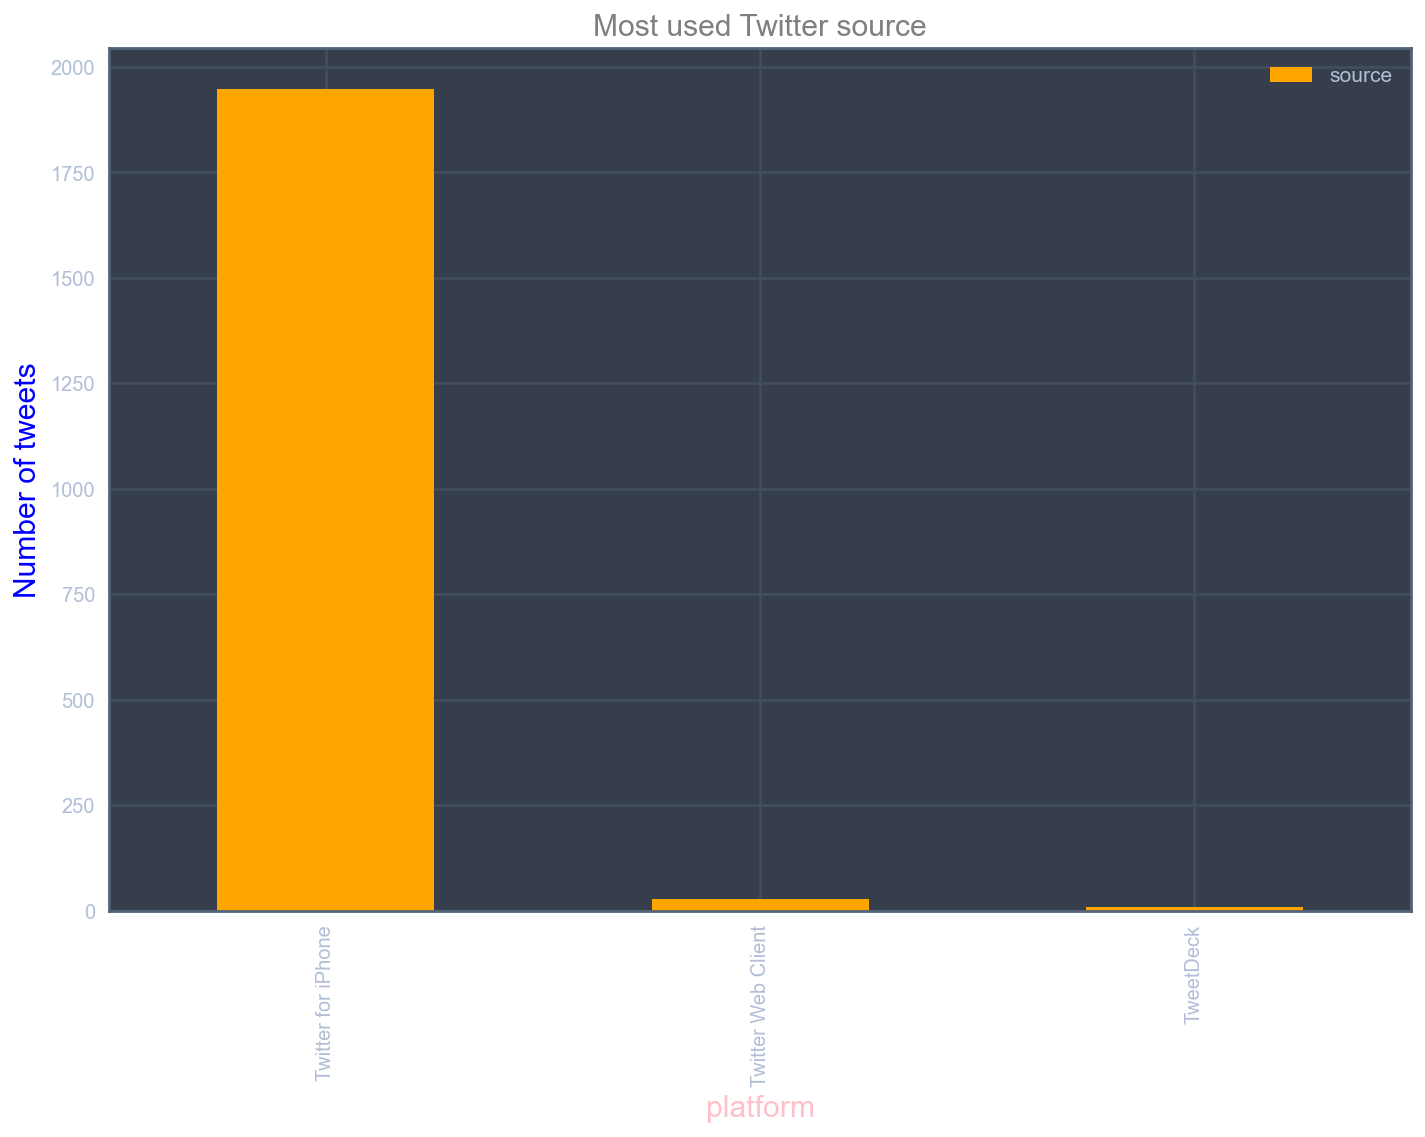

In [183]:
#Popular twitter source plot "ptsp"
ptsp = popular_devices.plot.bar(color = 'orange', fontsize = 10)
ptsp.figure.set_size_inches(10, 8)
plt.title('Most used Twitter source', color = 'gray', fontsize = '15')
plt.xlabel('platform', color = 'pink', fontsize = '15')
plt.ylabel('Number of tweets', color = 'blue', fontsize = '15');
plt.legend(loc='upper right')
# plt.show()

In [184]:
#popular dog names excluding the None names occurence

In [185]:
p_dog = twitter_archive_master.name.value_counts()[1:12]

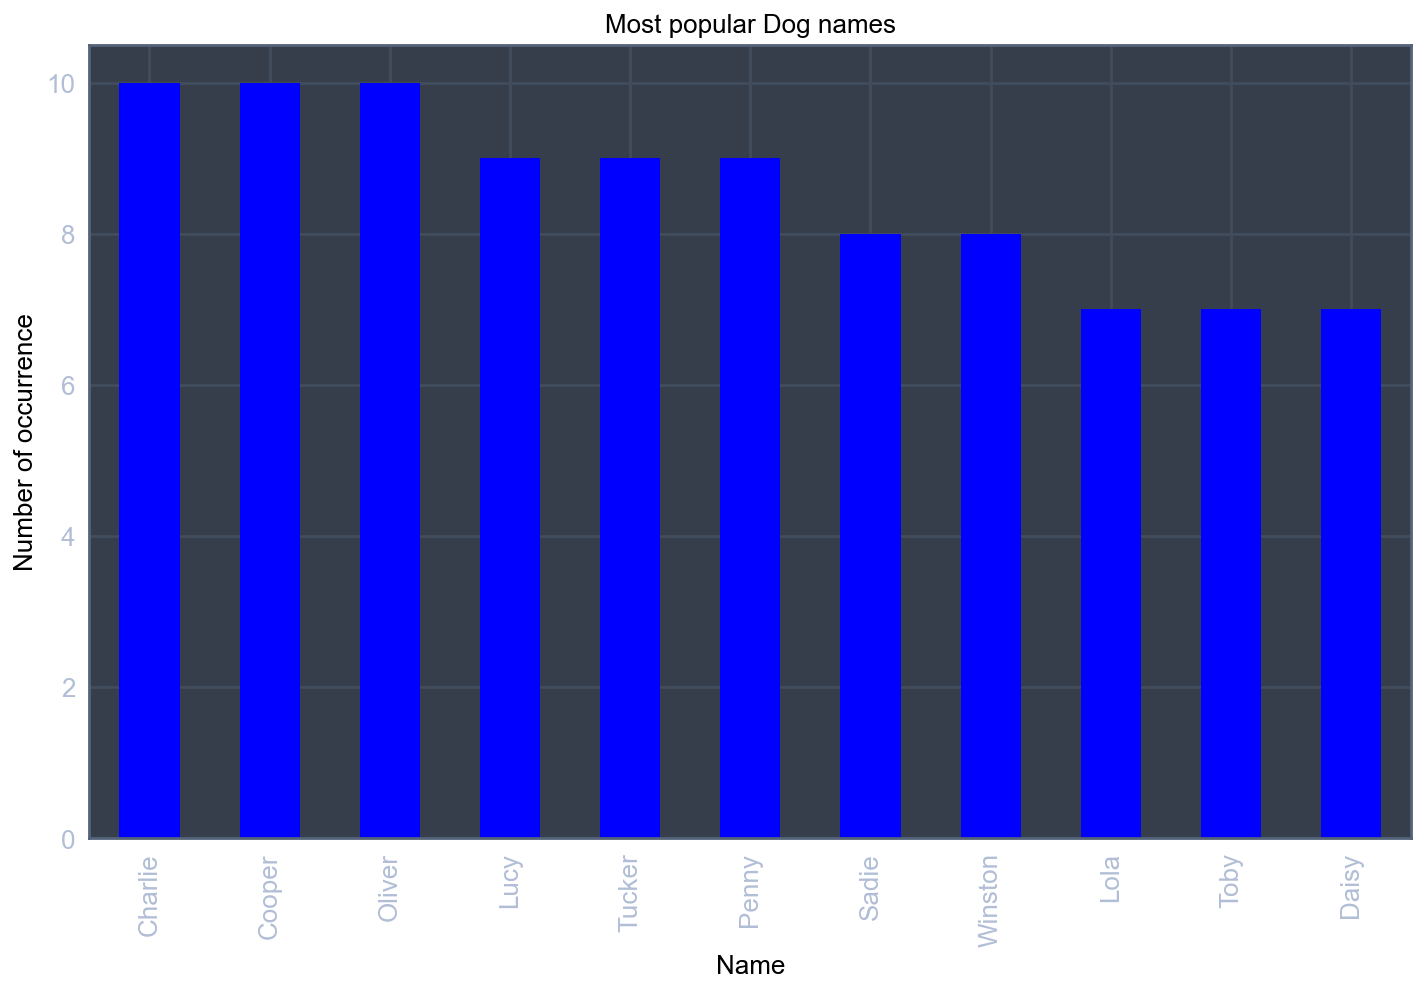

In [186]:
#plot
doggy = p_dog.plot.bar(color = 'blue', fontsize = 13)

#figure size(width, height)
doggy.figure.set_size_inches(10, 7);

#Add labels
plt.title('Most popular Dog names', color = 'black', fontsize = '13')
plt.xlabel('Name', color = 'black', fontsize = '13')
plt.ylabel('Number of occurrence', color = 'black', fontsize = '13');

### Insight 2:

In [187]:
twitter_archive_master['p1'].value_counts()

golden_retriever      139
Labrador_retriever     92
Pembroke               88
Chihuahua              79
pug                    54
                     ... 
nail                    1
timber_wolf             1
espresso                1
bib                     1
desktop_computer        1
Name: p1, Length: 374, dtype: int64

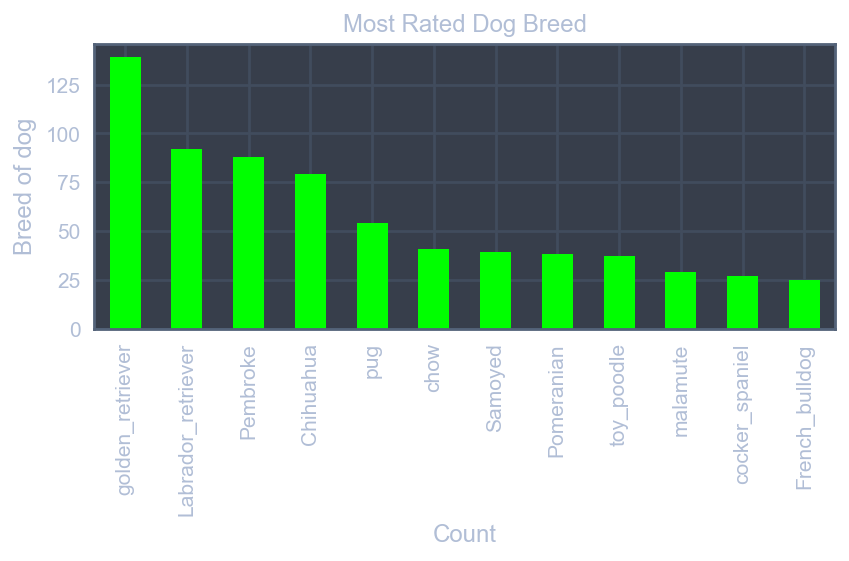

In [188]:
# Histogram to visualize dog breeeds >25
top_breed = twitter_archive_master.groupby('p1').filter(lambda x: len(x) >= 25)

top_breed['p1'].value_counts().plot(kind = 'bar', color= 'lime')
plt.title('Most Rated Dog Breed')
plt.xlabel('Count')
plt.ylabel('Breed of dog');

### Insight 3:

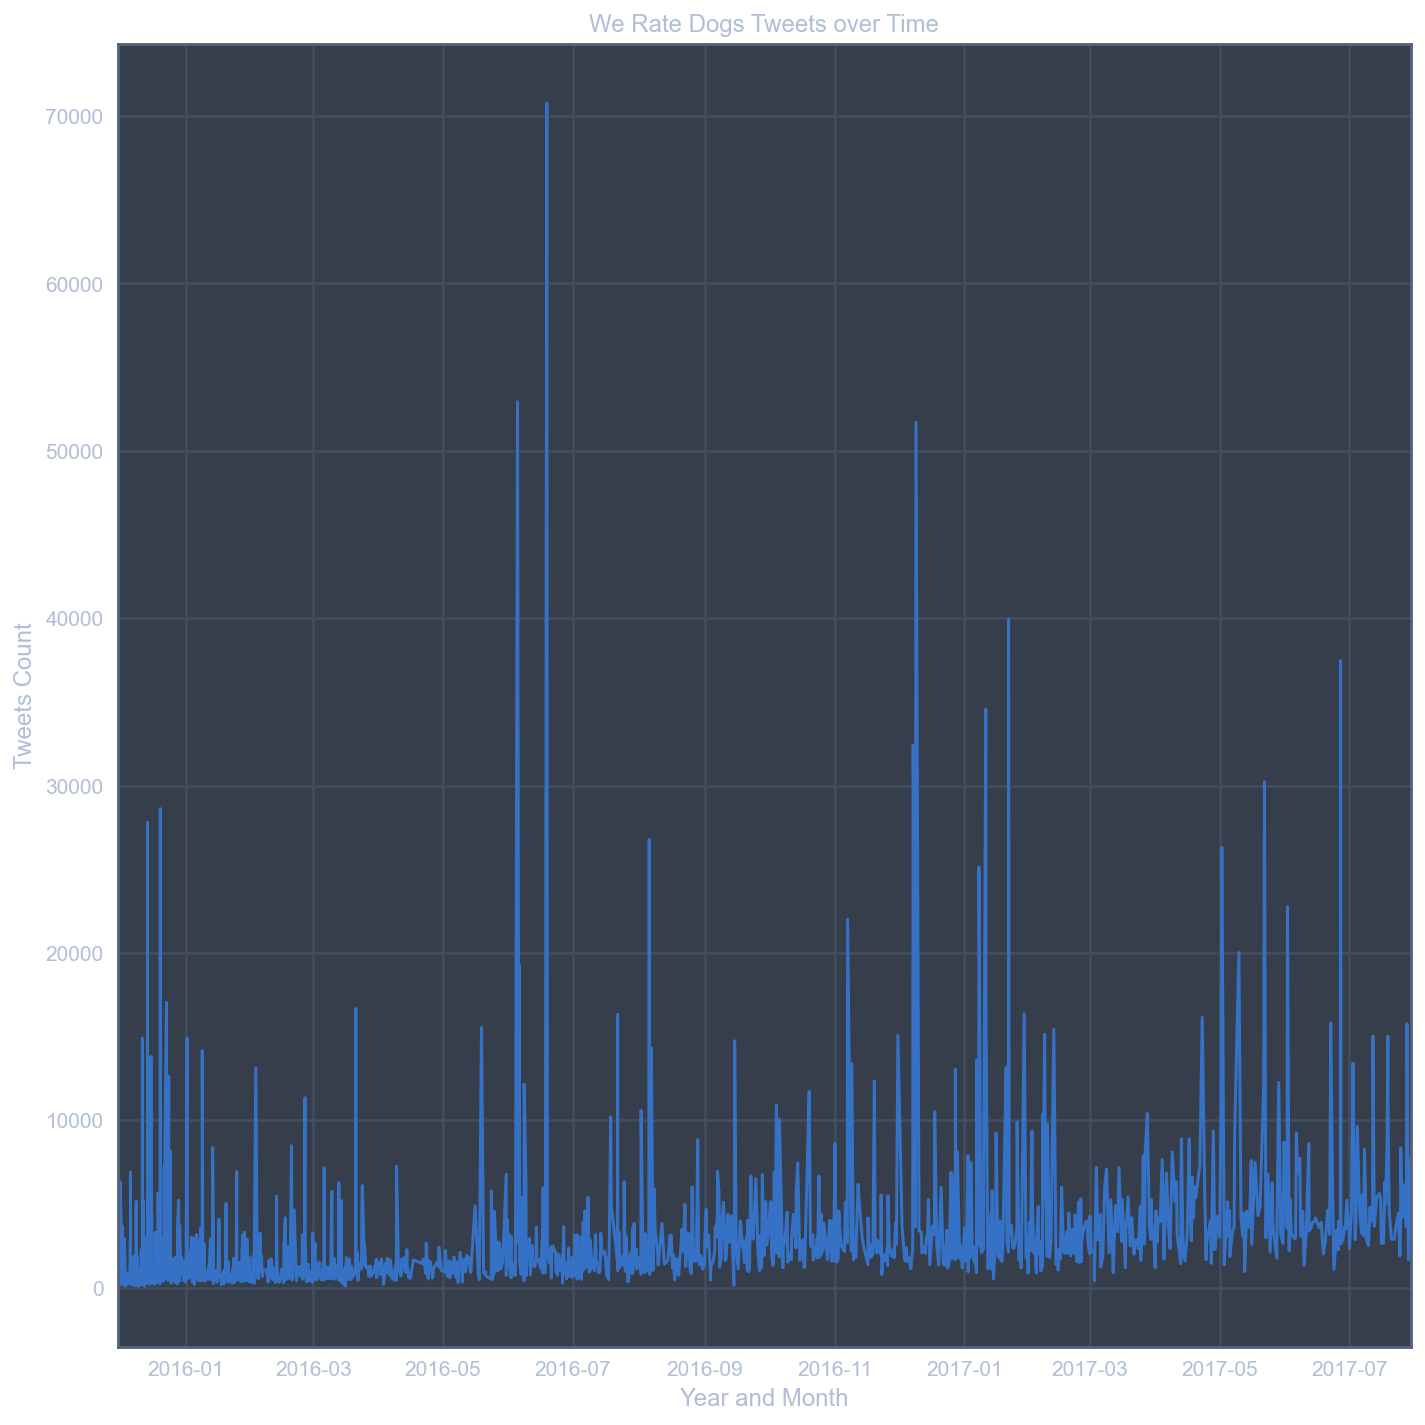

In [189]:
# Plotting time vs. tweets
sns.set_context()
plt.figure(figsize=(10, 10));
plt.xlim([datetime.date(2015, 11, 30), datetime.date(2017, 7, 30)]);

plt.xlabel('Year and Month')
plt.ylabel('Tweets Count')

plt.plot(twitter_archive_master.timestamp, twitter_archive_master.retweet_count);
plt.title('We Rate Dogs Tweets over Time');

In [190]:
# #plot
# sns.set_context()
# plt.subplots(figsize=(25, 16))
# plt.plot(twitter_archive_master.timestamp, twitter_archive_master.retweet_count)
# plt.title('Retweets over time', color = 'black', fontsize = '18')
# plt.xlabel('Year and month', color = 'black', fontsize = '18')
# plt.ylabel('Number of retweets', color = 'black', fontsize = '18');

### Insight 4:

In [191]:
#Dog_stage popularity count

In [192]:
twitter_archive_master['dog_stage'].value_counts()

None        1681
Pupper       203
Doggo         62
Puppo         22
Multiple      11
Floofer        7
Name: dog_stage, dtype: int64

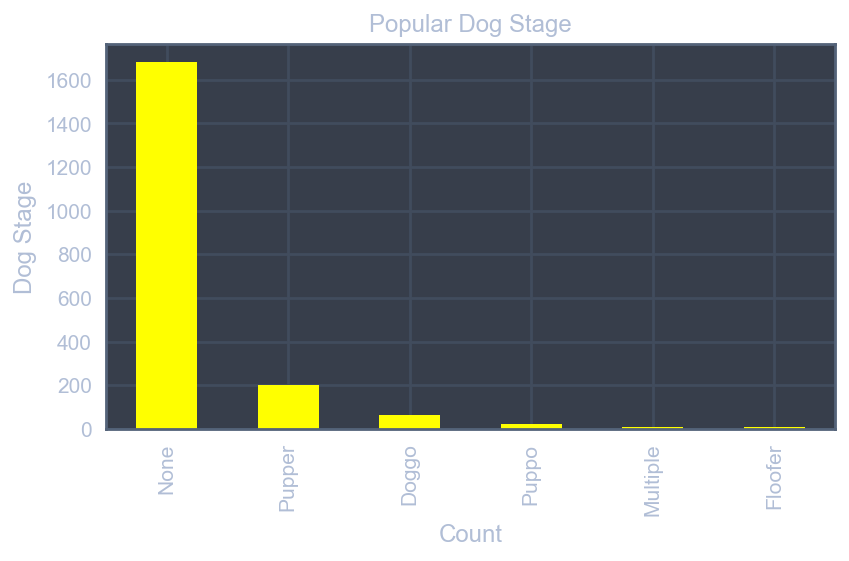

In [193]:
twitter_archive_master['dog_stage'].value_counts().plot(kind = 'bar', color= 'yellow')
plt.title('Popular Dog Stage')
plt.xlabel('Count')
plt.ylabel('Dog Stage');